<a href="https://colab.research.google.com/github/mdkamrulhasan/machine_learning_concepts/blob/master/notebooks/supervised/Classification_cifar_10_pca_hp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What will we cover today ?


1.   RF performance on CIFAR-10 data


In [1]:
import numpy as np
import pandas as pd
# Models (Sklearn)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Data and Evaluation packages
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
# visualization
import plotly.express as px
from sklearn.model_selection import train_test_split

# Our Wrapper Class (Can take any model as an input)

In [41]:
from sklearn.model_selection import cross_val_score

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

class myClassificationModel:
  def __init__(self, model):
    self.model = model
    self.nb_cv_splits = 5
    self.evaluation_metrics = 'accuracy' #'f1'

    # grid search RF
    self.param_RF_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10], 'n_estimators': [10, 50, 100, 200]}

  def train(self, X, y):
    self.model.fit(X, y)

  def evaluate(self, X, y):
    y_predict = self.model.predict(X)
    # return mean_squared_error(y, y_predict)
    return accuracy_score(y, y_predict)

  def cv_error(self, X, y):
    return cross_val_score(self.model,
                           X,
                           y, scoring=self.evaluation_metrics,
                           cv=self.nb_cv_splits)


  def grid_search_hp(self, X, y):

    #base_estimator = RandomForestRegressor(random_state=0)
    sh = HalvingGridSearchCV(self.model, self.param_RF_grid, cv=5,
                         factor=2, #resource='n_estimators',
                         max_resources=500).fit(X, y)

    self.model = sh.best_estimator_


# [Data description](https://www.cs.toronto.edu/~kriz/cifar.html#:~:text=The%20CIFAR%2D10%20dataset%20consists,batch%2C%20each%20with%2010000%20images.)

In [22]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [23]:
X_train.shape

(50000, 32, 32, 3)

<Figure size 640x480 with 0 Axes>

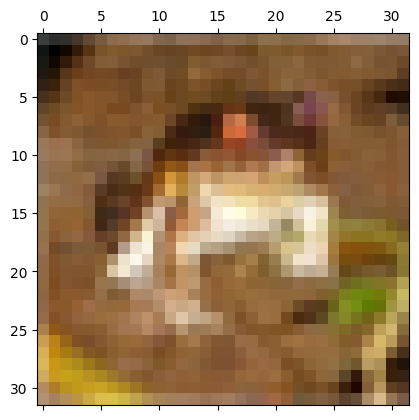

In [24]:
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(X_train[0])
#plt.matshow(X_train[1])
plt.show()

## Unique y values (i.e the labels)

In [25]:
set(y_train.flatten()), set(y_test.flatten())

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

## Are the feature values scaled/normalized ?

In [26]:
X_train.min(), X_train.max()

(0, 255)

## Lets normalize the features.

In [27]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [28]:
X_train.min(), X_train.max()

(0.0, 1.0)

# Imporing and fitting the PCA model

In [29]:
# importing PCA module
from sklearn.decomposition import PCA

In [30]:
X_train.shape

(50000, 32, 32, 3)

In [61]:
# transforming to 1D vector
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = y_train.flatten()
X_test = X_test.reshape(X_test.shape[0], -1)
y_test = y_test.flatten()

In [62]:
# fitting the PCA model
pca = PCA(n_components=200)
pca.fit(X_train)

PCA(n_components=200)

In [63]:
# perform copression
X_train_compressed = pca.transform(X_train)
X_train.shape, X_train_compressed.shape

((50000, 3072), (50000, 200))

In [64]:
# plotting the per component variances
fig = px.bar(x=np.arange(X_train_compressed.shape[1]), y=pca.explained_variance_ratio_)
fig.show()
print(np.sum(pca.explained_variance_ratio_))

0.94574124


# Model testing with raw data

In [65]:
model_repo = {
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier(),
    'svm': SVC()
}

In [66]:
# testing a model type
my_model = myClassificationModel(model_repo['rf'])

In [67]:
# cv_scores = my_model.cv_error(X_train, y_train)
# print('cross validation scores:', cv_scores)
# print('cross validation score (mean):', np.mean(cv_scores))
# print('cross validation score (std):', np.std(cv_scores))

# Model testing with compressed data

In [68]:
cv_scores = my_model.cv_error(X_train_compressed, y_train)
print('cross validation scores:', cv_scores)
print('cross validation score (mean):', np.mean(cv_scores))
print('cross validation score (std):', np.std(cv_scores))

cross validation scores: [0.4407 0.4256 0.4378 0.4243 0.4383]
cross validation score (mean): 0.43334
cross validation score (std): 0.006932416606061703


# With HP optimization

In [69]:
# my_model = myClassificationModel(model_repo['rf'])
my_model = myClassificationModel(RandomForestClassifier(random_state=0))
my_model.grid_search_hp(X_train_compressed, y_train)

# evaluate
cv_scores = my_model.cv_error(X_train_compressed, y_train)
print('cross validation scores:', cv_scores)
print('cross validation score (mean):', np.mean(cv_scores))
print('cross validation score (std):', np.std(cv_scores))

cross validation scores: [0.4401 0.4296 0.4442 0.4219 0.4319]
cross validation score (mean): 0.43354
cross validation score (std): 0.007878730862264554


# How about plotting the data?
- We will have hard time plotting 64D data matrix; right?

In [70]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train)

In [71]:
X_2D.shape

(50000, 2)

In [73]:
df_2D = pd.DataFrame({'f1':X_2D[:,0],
                      'f2':X_2D[:,1],
                      'y':y_train})
df_2D.head(2)

,f1,f2,y
0,-6.401149,2.728982,6
1,0.829713,-0.949809,9


In [74]:
fig = px.scatter(df_2D, x="f1", y="f2", color="y",
                 title="String 'y(digits)' values mean discrete colors")

fig.show()